# Pharmaceutical Dispensing Analysis

This notebook analyzes pharmaceutical dispensing trends across different regions and identifies the most commonly dispensed chemicals on a national level. The pipeline includes data cleaning, integration with population statistics, and per-capita trend visualization.

## Environmental Set-Up

In [15]:
# --- Dependencies Installation ---
# !mamba install pandas numpy matplotlib seaborn
%pip install pandas numpy matplotlib seaborn
print('Requirements installed successfully.')

Requirements installed successfully


## 1. Data Processing Functions

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration ---
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 12

# District to Region Mapping
DISTRICT_TO_REGION_MAP = {
    'Auckland': 'Auckland Region', 'Waitemata': 'Auckland Region', 'Counties Manukau': 'Auckland Region',
    'Canterbury': 'Canterbury Region', 'South Canterbury': 'Canterbury Region',
    'Southern': 'Otago Region',
    'Capital & Coast': 'Wellington Region', 'Hutt Valley': 'Wellington Region', 'Wairarapa': 'Wellington Region',
    'MidCentral': 'Manawatu-Wanganui Region', 'Whanganui': 'Manawatu-Wanganui Region',
    'Lakes': 'Bay of Plenty Region', 'Bay of Plenty': 'Bay of Plenty Region',
    'Tairawhiti': 'Gisborne Region',
    'Northland': 'Northland Region',
    'Waikato': 'Waikato Region',
    "Hawke's Bay": "Hawke's Bay Region",
    'Taranaki': 'Taranaki Region',
    'West Coast': 'West Coast Region'
}

EXCLUDED_LOCATIONS = ['New Zealand', 'New Zeland', 'Unknown', 'unknown']
print('Initialized region information.')

Initialized region information.


In [17]:
def load_and_clean_pharma_data(file_path: str) -> pd.DataFrame:
    """
    Loads pharmaceutical data, normalizes column names, handles low-volume redactions,
    and maps districts to broader regions.
    """
    df = pd.read_csv(file_path)

    # Standardize column names
    df = df.rename(columns={
        'Type': 'Dispensing_Type',
        'ChemID': 'Chemical_ID',
        'Chemical': 'Chemical_Name',
        'District': 'District',
        'YearDisp': 'Year',
        'NumDisps': 'Count_Dispensings',
        'NumPpl': 'Count_People',
        'NHIComp': 'NHI_Completeness'
    })

    # Handle redacted values ('<6') by imputing a median value of 5 (or 3 depending on preference)
    # Remove commas to ensure numeric conversion
    for col in ['Count_Dispensings', 'Count_People']:
        df[col] = df[col].astype(str).str.replace('<6', '5').str.replace(',', '')
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Filter out unknown or aggregate locations from the source
    df_cleaned = df[~df['District'].isin(EXCLUDED_LOCATIONS)].copy()
    
    # Apply Region Mapping
    df_cleaned['Region'] = df_cleaned['District'].map(DISTRICT_TO_REGION_MAP)
    
    return df_cleaned

def prepare_population_data(file_path: str) -> pd.DataFrame:
    """
    Loads population data and reshapes it (melt) for merging with pharmaceutical data.
    Returns a DataFrame with columns: [Year, Region, Population_Count]
    """
    df = pd.read_csv(file_path)
    
    pop_melted = df.melt(
        id_vars=['Year'],
        var_name='Region',
        value_name='Population_Count'
    )
    
    # Exclude macro-regions to prevent double counting during specific merges
    pop_final = pop_melted[~pop_melted['Region'].isin(['New Zealand', 'North Island', 'South Island'])]
    return pop_final

def get_national_population(file_path: str) -> pd.DataFrame:
    """
    Extracts only the national 'New Zealand' population rows for national-level analysis.
    """
    df = pd.read_csv(file_path)
    pop_melted = df.melt(id_vars=['Year'], var_name='Region', value_name='Population_Count')
    return pop_melted[pop_melted['Region'] == 'New Zealand']

print('Defined data processing functions.')

Defined data processing functions.


## 2. Visualization Functions

In [18]:
def plot_regional_per_capita_trends(pharma_df: pd.DataFrame, pop_df: pd.DataFrame):
    """
    Calculates and plots the per-capita dispensing trends for each region over time.
    """
    # Filter for 'Dispensings' type only (ignoring 'Initial dispensings' if present)
    dispenses_df = pharma_df[pharma_df['Dispensing_Type'] == 'Dispensings']
    
    # Aggregate dispensing counts by Year and Region
    regional_usage = dispenses_df.groupby(['Year', 'Region'])['Count_Dispensings'].sum().reset_index()
    
    # Merge with regional population data
    merged_df = pd.merge(regional_usage, pop_df, on=['Year', 'Region'])
    
    # Calculate Per Capita metric
    merged_df['Dispensings_Per_Capita'] = merged_df['Count_Dispensings'] / merged_df['Population_Count']
    
    # Visualization
    plt.figure(figsize=(12, 7))
    sns.lineplot(
        data=merged_df,
        x='Year',
        y='Dispensings_Per_Capita',
        hue='Region',
        marker='o',
        linewidth=2
    )
    
    plt.title('Trend of Dispensings Per Capita by Region', fontsize=16, fontweight='bold')
    plt.xlabel('Year')
    plt.ylabel('Dispensings Per Capita')
    plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Ensure x-axis shows integer years only
    unique_years = sorted(merged_df['Year'].unique())
    plt.xticks(unique_years)
    plt.tight_layout()
    plt.show()

def plot_top_chemicals_national_trends(pharma_df: pd.DataFrame, national_pop_df: pd.DataFrame, top_k: int = 10):
    """
    Identifies the top K most dispensed chemicals (by total volume) and plots 
    their national per-capita trends over time.
    """
    dispenses_df = pharma_df[pharma_df['Dispensing_Type'] == 'Dispensings']
    
    # 1. Identify Top K Chemicals by total volume across all years
    chemical_totals = dispenses_df.groupby('Chemical_Name')['Count_Dispensings'].sum()
    top_chemicals = chemical_totals.nlargest(top_k).index.tolist()
    
    print(f"Top {top_k} Chemicals identified:")
    for i, chem in enumerate(top_chemicals, 1):
        print(f"{i}. {chem}")

    # 2. Aggregate national usage per chemical per year
    national_dispensing = dispenses_df.groupby(['Year', 'Chemical_Name'])['Count_Dispensings'].sum().reset_index()
    
    # 3. Merge with National Population
    merged_df = pd.merge(national_dispensing, national_pop_df, on='Year')
    
    # 4. Calculate Per Capita
    merged_df['Dispensings_Per_Capita'] = merged_df['Count_Dispensings'] / merged_df['Population_Count']
    
    # 5. Filter for only the top chemicals
    plot_data = merged_df[merged_df['Chemical_Name'].isin(top_chemicals)].copy()
    
    # Convert Year to string for categorical plotting if needed, or keep as int
    plot_data['Year'] = plot_data['Year'].astype(str)
    
    # Visualization
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=plot_data,
        x='Year',
        y='Dispensings_Per_Capita',
        hue='Chemical_Name',
        marker='o',
        linewidth=2
    )
    
    plt.title(f'Top {top_k} Chemicals: National Dispensing Trends Per Capita', fontsize=16, fontweight='bold')
    plt.ylabel('Dispensings Per Person')
    plt.xlabel('Year')
    plt.legend(title='Chemical Name', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def plot_chronic_maintenance_analysis(df, chronic_list):
    """
    Analyzes the balance between new treatment starts (Initial) and 
    long-term care (Maintenance) for selected chronic medications.
    """
    # 1. Filter and Aggregate
    mask = df['Chemical_Name'].isin(chronic_list)
    subset = df[mask].groupby(['Year', 'Chemical_Name', 'Dispensing_Type'])['Count_Dispensings'].sum().unstack()
    
    # 2. Calculate Maintenance and Initial Percentage
    subset['Maintenance'] = subset['Dispensings'] - subset['Initial dispensings']
    subset['Initial_Rate_Pct'] = (subset['Initial dispensings'] / subset['Dispensings']) * 100
    
    # Reset index for Seaborn
    plot_df = subset.reset_index()

    plot_df['Year'] = plot_df['Year'].astype(str)
    
    # 3. Create a dual-facet plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), sharex=True)

    # Plot A: Total Volume (Stacked) for one example to show composition
    example_med = chronic_list[0]
    example_data = plot_df[plot_df['Chemical_Name'] == example_med]
    example_data.set_index('Year')[['Initial dispensings', 'Maintenance']].plot(
        kind='bar', stacked=True, ax=ax1, color=['#ff9999','#66b3ff']
    )
    ax1.set_title(f'Dispensing Composition: {example_med} (New vs. Ongoing)', fontsize=14)
    ax1.set_ylabel('Total Count')

    # Plot B: The "New Start Rate" for all 5 medications
    sns.lineplot(data=plot_df, x='Year', y='Initial_Rate_Pct', hue='Chemical_Name', marker='o', ax=ax2)
    ax2.set_title('Percentage of "Initial" Dispensings (New Patient Onboarding)', fontsize=14)
    ax2.set_ylabel('% Initial Rate')
    ax2.set_ylim(0, 100) # Chronic meds usually have a low initial rate (e.g., <20%)
    
    plt.tight_layout()
    plt.show()

print('Defined data visualization functions.')

Defined data visualization functions.


## 3. Analysis Execution

Data loaded and cleaned successfully.


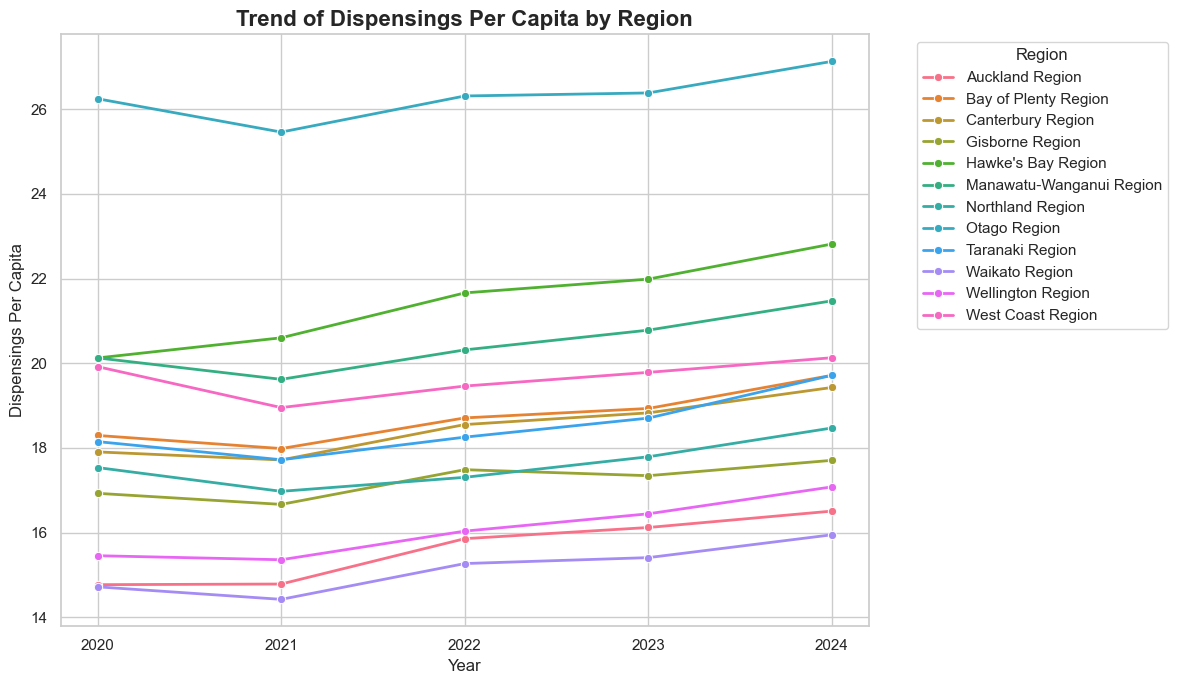

Top 10 Chemicals identified:
1. Paracetamol
2. Atorvastatin
3. Omeprazole
4. Aspirin
5. Metoprolol succinate
6. Colecalciferol
7. Methadone hydrochloride
8. Salbutamol
9. Zopiclone
10. Ibuprofen


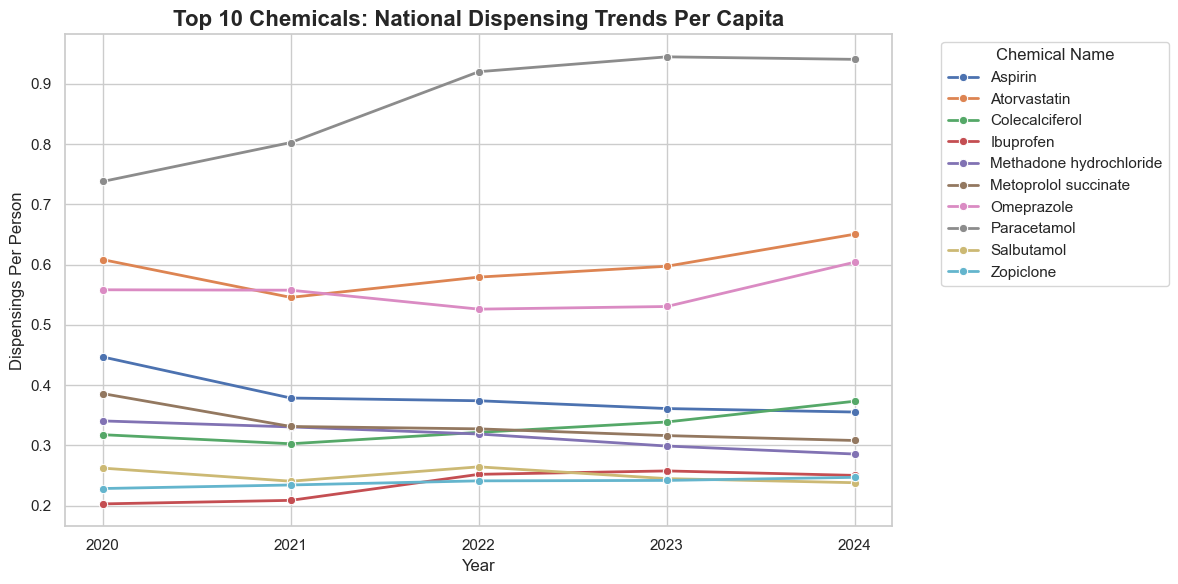

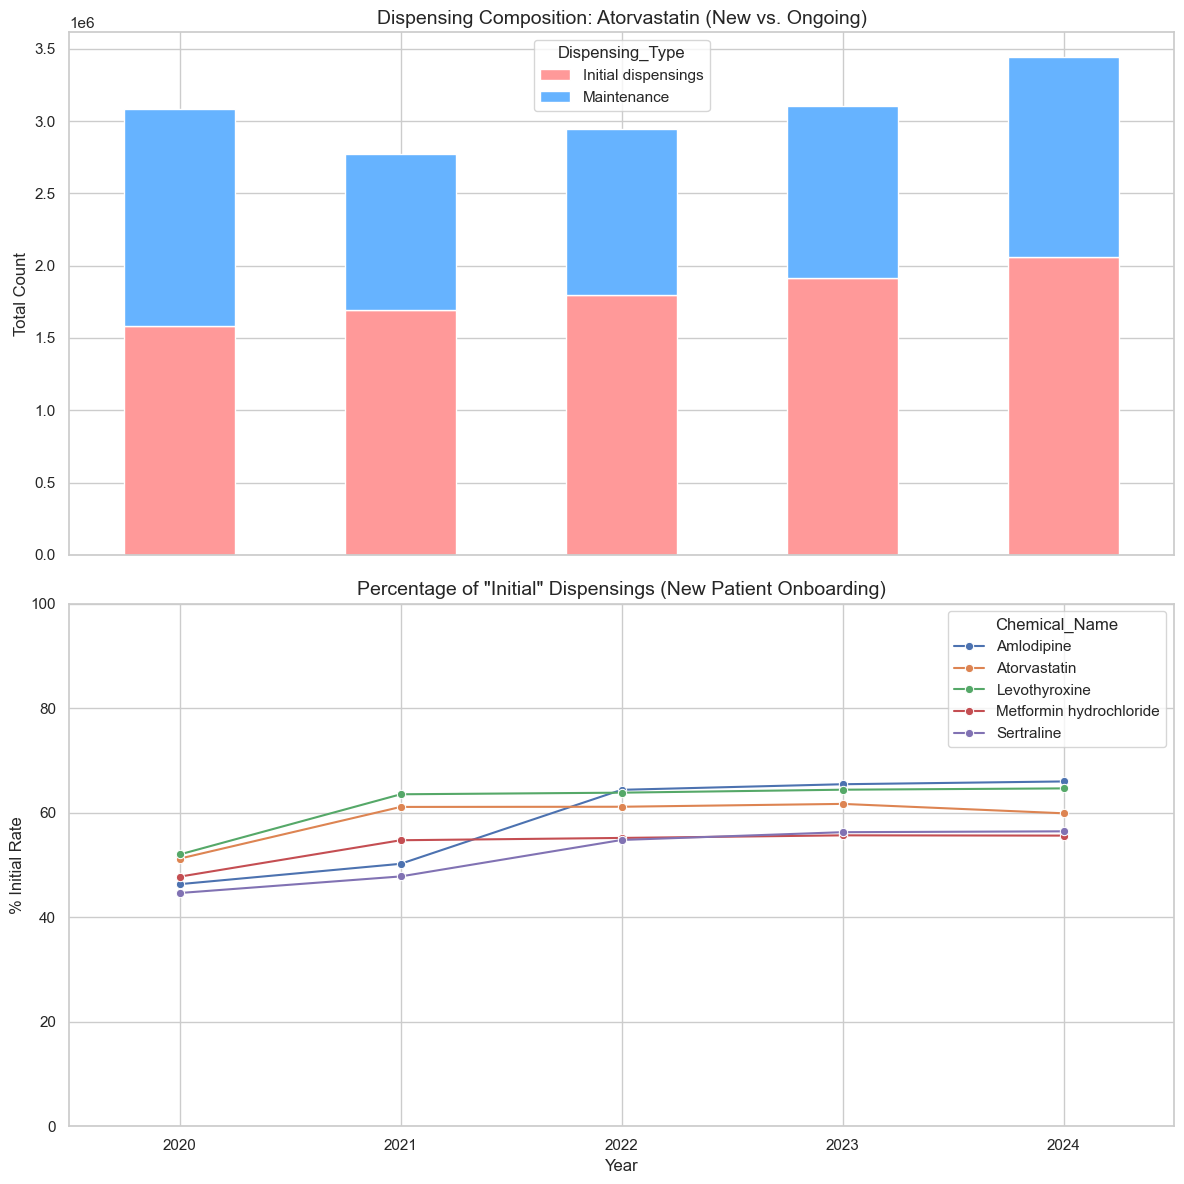

In [14]:
# --- Step 1: Load and Clean Data ---
# Ensure 'Data_ByChemical.csv' and 'Population_Data_Latest.csv' are in the working directory
pharma_data_path = "./data/Data_ByChemical.csv"
population_data_path = "./data/Population_Data_Latest.csv"
pharma_data = load_and_clean_pharma_data(pharma_data_path)
regional_pop_data = prepare_population_data(population_data_path)
national_pop_data = get_national_population(population_data_path)

# Save cleaned version for records
pharma_data.to_csv("./data/Cleaned_Pharma_Data.csv", index=False)
print("Data loaded and cleaned successfully.")

# --- Step 2: Regional Trends Analysis ---
plot_regional_per_capita_trends(pharma_data, regional_pop_data)

# --- Step 3: Top Chemicals Analysis ---
plot_top_chemicals_national_trends(pharma_data, national_pop_data, top_k=10)

# --- Step 4: Chronic Medication Analysis ---
target_meds = [
    'Atorvastatin',            # cholesterol
    'Sertraline',              # antidepressant
    'Metformin hydrochloride', # diabetes
    'Amlodipine',              # high blood pressure
    'Levothyroxine'            # thyroid hormone replacement
]

plot_chronic_maintenance_analysis(pharma_data, target_meds)